# Spectral Temporal Clustering (STC) for Hand Gesture Recognition

## Overview
This notebook implements **Spectral Temporal Clustering (STC)** - a graph-based temporal clustering method that combines:
- **Spatial structure**: Hand skeleton topology (42 landmarks)
- **Temporal structure**: Gesture sequences (150 frames per video)

### Key Features:
- ✅ **Spatial Laplacian**: Captures hand structure within each frame
- ✅ **Temporal Laplacian**: Captures frame-to-frame relationships
- ✅ **Joint Clustering**: Combines spatial and temporal information
- ✅ **Unsupervised**: No labels needed

### Dataset:
- **320 videos total**: 40 videos × 8 gestures
- **150 frames per video**
- **42 landmarks per frame** (21 landmarks × 2 hands)
- **126 features per frame** (42 landmarks × 3 coordinates)

### Gesture Types:
1. Cleaning
2. Come
3. Emergency Calling
4. Give
5. Good
6. Pick
7. Stack
8. Wave


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from scipy.sparse import csgraph, block_diag, diags, identity
from scipy.sparse.linalg import eigsh
import os
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

print("✅ All imports successful")


✅ All imports successful


In [3]:
# ============================================================================
# DATA LOADING: Configuration and Evaluation Data
# ============================================================================

# Configuration
base_data_path = '../input_gesture_1'
GESTURE_TYPES = ['Cleaning', 'Come', 'Emergency_calling', 'Give', 'Good', 'Pick', 'Stack', 'Wave']
LANDMARKS_PER_FRAME = 42  # 21 landmarks × 2 hands
FEATURES_PER_FRAME = LANDMARKS_PER_FRAME * 3  # 126 features
FRAMES_PER_VIDEO = 150  # 5 seconds × 30 fps
EXPECTED_VIDEOS = 320   # 40 videos × 8 gestures

print("\n" + "=" * 70)
print("Loading Individual Gesture Folders for EVALUATION")
print("=" * 70)
print("Note: This data will be used for accuracy evaluation only")
print("=" * 70)

sequences_eval = []
gesture_labels_eval = []  # Ground truth labels
video_metadata_eval = []

for gesture_idx, gesture_name in enumerate(GESTURE_TYPES):
    gesture_folder = os.path.join(base_data_path, gesture_name)
    if os.path.exists(gesture_folder):
        csv_files = sorted([f for f in os.listdir(gesture_folder) if f.endswith('.csv')])
        print(f"{gesture_name}: {len(csv_files)} videos")
        
        for csv_file in csv_files:
            file_path = os.path.join(gesture_folder, csv_file)
            df = pd.read_csv(file_path)
            video_data = df.values  # (n_rows, 3)
            
            # Reshape: (n_rows, 3) → (n_frames, 42, 3) → (n_frames, 126)
            n_rows = len(video_data)
            n_frames = n_rows // LANDMARKS_PER_FRAME
            
            if n_frames > 0:
                # Trim to complete frames
                video_data_trimmed = video_data[:n_frames * LANDMARKS_PER_FRAME]
                frames = video_data_trimmed.reshape(n_frames, LANDMARKS_PER_FRAME, 3)
                frames_flat = frames.reshape(n_frames, FEATURES_PER_FRAME)
                
                # Remove zero-padding frames
                zero_threshold = 1e-6
                non_zero_mask = ~np.all(np.abs(frames_flat) < zero_threshold, axis=1)
                sequence = frames_flat[non_zero_mask]
                
                if len(sequence) >= 10:  # Minimum sequence length
                    sequences_eval.append(sequence)
                    gesture_labels_eval.append(gesture_idx)
                    video_metadata_eval.append({
                        'gesture': gesture_name,
                        'video_file': csv_file,
                        'n_frames': len(sequence),
                        'gesture_idx': gesture_idx
                    })

print(f"\n✅ Loaded {len(sequences_eval)} video sequences for evaluation")
print(f"   Average sequence length: {np.mean([len(s) for s in sequences_eval]):.1f} frames")
print(f"   Sequence length range: {min([len(s) for s in sequences_eval])} - {max([len(s) for s in sequences_eval])} frames")
print(f"   Expected: 320 videos (40 videos × 8 gestures)")

# Store evaluation data
SEQUENCES_EVAL = sequences_eval
GESTURE_LABELS_EVAL = np.array(gesture_labels_eval)
VIDEO_METADATA_EVAL = video_metadata_eval



Loading Individual Gesture Folders for EVALUATION
Note: This data will be used for accuracy evaluation only
Cleaning: 40 videos
Come: 40 videos
Emergency_calling: 40 videos
Give: 40 videos
Good: 40 videos
Pick: 40 videos
Stack: 40 videos
Wave: 40 videos

✅ Loaded 320 video sequences for evaluation
   Average sequence length: 149.1 frames
   Sequence length range: 80 - 150 frames
   Expected: 320 videos (40 videos × 8 gestures)


In [4]:
# ============================================================================
# DATA LOADING: Training Data from combined.csv
# ============================================================================

combined_file = os.path.join(base_data_path, 'combined.csv')

print("\n" + "=" * 70)
print("Loading combined.csv for TRAINING")
print("=" * 70)

# Load combined.csv
df_combined = pd.read_csv(combined_file)
X_raw = df_combined.values  # (n_rows, 3)

print(f"Combined.csv shape: {X_raw.shape}")
print(f"Columns: {list(df_combined.columns)}")

def segment_sequences_fixed(X_raw, landmarks_per_frame=42, frames_per_video=150):
    """
    Segment combined.csv into fixed-length sequences.
    Each video is exactly 150 frames (5 seconds at 30 fps).
    
    Parameters:
    -----------
    landmarks_per_frame : int
        Number of landmarks per frame (42 for double hand, 21 for single hand)
    frames_per_video : int
        Fixed number of frames per video (150 = 5 seconds × 30 fps)
    """
    sequences = []
    n_rows = len(X_raw)
    
    # Calculate total frames
    n_frames = n_rows // landmarks_per_frame
    n_videos = n_frames // frames_per_video
    
    print(f"   Total frames in combined.csv: {n_frames:,}")
    print(f"   Expected videos: {EXPECTED_VIDEOS}")
    print(f"   Calculated videos: {n_videos}")
    print(f"   Frames per video: {frames_per_video}")
    
    # Reshape to frames: (n_rows, 3) → (n_frames, landmarks_per_frame, 3)
    X_trimmed = X_raw[:n_frames * landmarks_per_frame]
    frames = X_trimmed.reshape(n_frames, landmarks_per_frame, 3)
    frames_flat = frames.reshape(n_frames, FEATURES_PER_FRAME)
    
    # Split into fixed-length sequences (150 frames each)
    for video_idx in range(n_videos):
        start_frame = video_idx * frames_per_video
        end_frame = start_frame + frames_per_video
        video_sequence = frames_flat[start_frame:end_frame]
        
        # Remove zero-padding frames within the video
        zero_threshold = 1e-6
        non_zero_mask = ~np.all(np.abs(video_sequence) < zero_threshold, axis=1)
        video_sequence_clean = video_sequence[non_zero_mask]
        
        # Only add if sequence has sufficient non-zero frames
        if len(video_sequence_clean) >= 50:  # At least 50 frames of actual data
            sequences.append(video_sequence_clean)
        else:
            # If too many zeros, use original sequence
            sequences.append(video_sequence)
    
    return sequences

# Segment combined.csv into fixed 150-frame sequences
sequences_train = segment_sequences_fixed(X_raw, LANDMARKS_PER_FRAME, FRAMES_PER_VIDEO)

print(f"\n✅ Segmented combined.csv into {len(sequences_train)} sequences")
print(f"   Average sequence length: {np.mean([len(s) for s in sequences_train]):.1f} frames")
print(f"   Sequence length range: {min([len(s) for s in sequences_train])} - {max([len(s) for s in sequences_train])} frames")
print(f"   Total frames: {sum(len(s) for s in sequences_train):,}")

# Verify we got the expected number of videos
if len(sequences_train) != EXPECTED_VIDEOS:
    print(f"\n⚠️ Warning: Expected {EXPECTED_VIDEOS} videos, got {len(sequences_train)}")
    print("   Some videos may have been filtered out due to excessive zero-padding.")
else:
    print(f"\n✅ Successfully extracted {EXPECTED_VIDEOS} videos (as expected)")
    
# Note about hand requirements
print(f"\n📝 Note on gesture types:")
print(f"   Double-hand gestures (42 landmarks): Cleaning, Emergency_calling, Good")
print(f"   Single-hand gestures (21 landmarks): Come, Give, Pick, Stack, Wave")
print(f"   Using 42 landmarks per frame (includes both hands, zeros for single-hand gestures)")

# Store training sequences
SEQUENCES_TRAIN = sequences_train



Loading combined.csv for TRAINING
Combined.csv shape: (2016000, 3)
Columns: ['X', 'Y', 'Z']
   Total frames in combined.csv: 48,000
   Expected videos: 320
   Calculated videos: 320
   Frames per video: 150

✅ Segmented combined.csv into 320 sequences
   Average sequence length: 149.9 frames
   Sequence length range: 143 - 150 frames
   Total frames: 47,954

✅ Successfully extracted 320 videos (as expected)

📝 Note on gesture types:
   Double-hand gestures (42 landmarks): Cleaning, Emergency_calling, Good
   Single-hand gestures (21 landmarks): Come, Give, Pick, Stack, Wave
   Using 42 landmarks per frame (includes both hands, zeros for single-hand gestures)


In [5]:
class SpectralTemporalClustering:
    """
    Spectral Temporal Clustering combines spatial and temporal graph structures
    for clustering gesture sequences.
    """
    
    def __init__(self, n_clusters=8, alpha=0.5, n_neighbors_spatial=5, 
                 n_neighbors_temporal=10, random_state=42,
                 use_temporal_features=True, temporal_feature_weights=None,
                 use_dtw=True, dtw_radius=1):
        """
        Parameters:
        -----------
        n_clusters : int
            Number of clusters (8 gestures)
        alpha : float
            Balance between spatial (0) and temporal (1) information
            alpha=0.5 means equal weight
        n_neighbors_spatial : int
            Number of neighbors for spatial k-NN graph (within frame)
        n_neighbors_temporal : int
            Number of neighbors for temporal k-NN graph (between sequences)
        random_state : int
            Random seed
        use_temporal_features : bool
            If False, use only mean frame similarity
        temporal_feature_weights : dict or None
            Custom weights for temporal features. If None, uses default weights.
            Format: {'static': 0.15, 'velocity': 0.20, ...}
        use_dtw : bool
            If True, use Dynamic Time Warping for sequence alignment before feature extraction
        dtw_radius : int
            Radius parameter for DTW (1 = standard DTW, larger = faster but less accurate)
        """
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.n_neighbors_spatial = n_neighbors_spatial
        self.n_neighbors_temporal = n_neighbors_temporal
        self.random_state = random_state
        self.use_temporal_features = use_temporal_features
        self.use_dtw = use_dtw
        self.dtw_radius = dtw_radius
        
        # Default temporal feature weights
        if temporal_feature_weights is None:
            self.temporal_weights = {
                'static': 0.15,
                'velocity': 0.20,
                'velocity_mag': 0.10,
                'acceleration': 0.10,
                'early': 0.10,
                'middle': 0.10,
                'late': 0.10,
                'trajectory': 0.10,
                'smoothness': 0.05
            }
        else:
            self.temporal_weights = temporal_feature_weights
    
    def _dtw_distance(self, seq1, seq2):
        """
        Compute Dynamic Time Warping distance between two sequences.
        Aligns sequences optimally before computing distance.
        
        Parameters:
        -----------
        seq1, seq2 : array (n_frames, n_features)
            Two gesture sequences
            
        Returns:
        --------
        dtw_dist : float
            DTW distance between sequences
        """
        n1, n2 = len(seq1), len(seq2)
        
        # Compute pairwise Euclidean distances between all frames
        # This is the cost matrix for DTW
        cost_matrix = np.zeros((n1, n2))
        for i in range(n1):
            for j in range(n2):
                cost_matrix[i, j] = np.linalg.norm(seq1[i] - seq2[j])
        
        # DTW dynamic programming: D[i,j] = min cost to align seq1[:i] with seq2[:j]
        D = np.full((n1 + 1, n2 + 1), np.inf)
        D[0, 0] = 0
        
        # Fill DP table
        for i in range(1, n1 + 1):
            for j in range(1, n2 + 1):
                # Cost of aligning seq1[i-1] with seq2[j-1]
                cost = cost_matrix[i-1, j-1]
                # Take minimum of three possible paths
                D[i, j] = cost + min(D[i-1, j],      # Insertion
                                     D[i, j-1],      # Deletion
                                     D[i-1, j-1])    # Match
        
        return D[n1, n2]
    
    def _dtw_align_sequences(self, seq1, seq2):
        """
        Align two sequences using DTW and return aligned sequences.
        Uses Sakoe-Chiba band for faster computation if radius is set.
        
        Parameters:
        -----------
        seq1, seq2 : array (n_frames, n_features)
            Two gesture sequences
            
        Returns:
        --------
        aligned_seq1, aligned_seq2 : arrays
            Aligned sequences (may have different lengths after warping)
        """
        n1, n2 = len(seq1), len(seq2)
        
        # Compute pairwise Euclidean distances
        cost_matrix = np.zeros((n1, n2))
        for i in range(n1):
            for j in range(n2):
                # Apply Sakoe-Chiba band if radius is set
                if self.dtw_radius > 0:
                    if abs(i - j) > self.dtw_radius * max(n1, n2):
                        cost_matrix[i, j] = np.inf
                    else:
                        cost_matrix[i, j] = np.linalg.norm(seq1[i] - seq2[j])
                else:
                    cost_matrix[i, j] = np.linalg.norm(seq1[i] - seq2[j])
        
        # DTW dynamic programming with path tracking
        D = np.full((n1 + 1, n2 + 1), np.inf)
        D[0, 0] = 0
        
        # Backtracking matrix to reconstruct alignment path
        path = {}
        
        for i in range(1, n1 + 1):
            for j in range(1, n2 + 1):
                if cost_matrix[i-1, j-1] == np.inf:
                    continue
                    
                cost = cost_matrix[i-1, j-1]
                candidates = [
                    (D[i-1, j], (i-1, j)),      # Insertion
                    (D[i, j-1], (i, j-1)),      # Deletion
                    (D[i-1, j-1], (i-1, j-1))   # Match
                ]
                min_val, prev = min(candidates, key=lambda x: x[0])
                D[i, j] = cost + min_val
                path[(i, j)] = prev
        
        # Reconstruct alignment path (backtracking)
        alignment = []
        i, j = n1, n2
        while i > 0 and j > 0:
            alignment.append((i-1, j-1))
            if (i, j) in path:
                i, j = path[(i, j)]
            else:
                # Fallback: move diagonally
                i -= 1
                j -= 1
        
        # Handle remaining frames
        while i > 0:
            alignment.append((i-1, 0))
            i -= 1
        while j > 0:
            alignment.append((0, j-1))
            j -= 1
        
        alignment.reverse()
        
        # Build aligned sequences
        aligned_seq1 = []
        aligned_seq2 = []
        for i_idx, j_idx in alignment:
            aligned_seq1.append(seq1[i_idx])
            aligned_seq2.append(seq2[j_idx])
        
        return np.array(aligned_seq1), np.array(aligned_seq2)
    
    def _compute_laplacian(self, W):
        """
        Compute normalized graph Laplacian: L = I - D^(-1/2) W D^(-1/2)
        
        Parameters:
        -----------
        W : sparse matrix
            Adjacency/affinity matrix
            
        Returns:
        --------
        L : sparse matrix
            Normalized Laplacian
        """
        # Degree matrix
        D = np.array(W.sum(axis=1)).flatten()
        D_sqrt_inv = 1.0 / np.sqrt(D + 1e-10)  # Avoid division by zero
        
        # Normalized Laplacian: L = I - D^(-1/2) W D^(-1/2)
        D_sqrt_inv_diag = diags(D_sqrt_inv, format=W.format)
        I = identity(W.shape[0], format=W.format)
        L = I - D_sqrt_inv_diag @ W @ D_sqrt_inv_diag
        
        return L
    
    def _build_spatial_graph(self, frame, landmarks_per_frame=42):
        """
        Build spatial graph for one frame (hand structure)
        
        Parameters:
        -----------
        frame : array (126,)
            One frame with 42 landmarks × 3 coordinates
        landmarks_per_frame : int
            Number of landmarks per frame (default 42)
            
        Returns:
        --------
        W_spatial : sparse matrix
            Spatial affinity matrix (42 × 42)
        """
        # Reshape to landmarks: (126,) → (42, 3)
        landmarks = frame.reshape(landmarks_per_frame, 3)
        
        # Build k-NN graph of landmarks
        W_spatial = kneighbors_graph(
            landmarks, 
            n_neighbors=self.n_neighbors_spatial,
            mode='connectivity',
            include_self=False
        )
        
        # Make symmetric
        W_spatial = (W_spatial + W_spatial.T) / 2
        
        return W_spatial
    
    def _extract_temporal_features(self, sequence):
        """
        Extract temporal features for 5-second video at 30fps.
        Captures motion dynamics, velocity, acceleration, and temporal phases.
        
        Parameters:
        -----------
        sequence : array (n_frames, n_features)
            Gesture sequence
            
        Returns:
        --------
        features : dict
            Dictionary of temporal features
        """
        n_frames = len(sequence)
        
        # 1. Velocity (frame-to-frame differences) - captures motion speed
        velocity = np.diff(sequence, axis=0)  # (n_frames-1, n_features)
        mean_velocity = np.mean(velocity, axis=0)
        velocity_magnitude = np.linalg.norm(mean_velocity)
        
        # 2. Acceleration (second-order differences) - captures motion changes
        if len(velocity) > 1:
            acceleration = np.diff(velocity, axis=0)  # (n_frames-2, n_features)
            mean_acceleration = np.mean(acceleration, axis=0)
            acceleration_magnitude = np.linalg.norm(mean_acceleration)
        else:
            mean_acceleration = np.zeros(sequence.shape[1])
            acceleration_magnitude = 0.0
        
        # 3. Temporal phases (early, middle, late) - captures gesture progression
        # Divide 5-second video into 3 phases: 0-1.67s, 1.67-3.33s, 3.33-5s
        phase_size = n_frames // 3
        early_phase = sequence[:phase_size] if phase_size > 0 else sequence[:1]
        middle_phase = sequence[phase_size:2*phase_size] if 2*phase_size <= n_frames else sequence[phase_size:]
        late_phase = sequence[2*phase_size:] if 2*phase_size < n_frames else sequence[-1:]
        
        early_mean = np.mean(early_phase, axis=0)
        middle_mean = np.mean(middle_phase, axis=0)
        late_mean = np.mean(late_phase, axis=0)
        
        # 4. Motion direction (trajectory)
        # Start to end vector
        trajectory = sequence[-1] - sequence[0]
        trajectory_magnitude = np.linalg.norm(trajectory)
        
        # 5. Motion smoothness (variance of velocity)
        velocity_variance = np.var(velocity, axis=0).mean() if len(velocity) > 0 else 0.0
        
        return {
            'mean_frame': np.mean(sequence, axis=0),
            'velocity': mean_velocity,
            'velocity_magnitude': velocity_magnitude,
            'acceleration': mean_acceleration,
            'acceleration_magnitude': acceleration_magnitude,
            'early_phase': early_mean,
            'middle_phase': middle_mean,
            'late_phase': late_mean,
            'trajectory': trajectory,
            'trajectory_magnitude': trajectory_magnitude,
            'velocity_variance': velocity_variance,
            'sequence_length': n_frames
        }
    
    def _compute_temporal_similarity(self, seq1, seq2):
        """
        Compute temporal similarity between two sequences
        IMPROVED: Uses temporal features for 5-second videos at 30fps
        Supports A/B testing with configurable weights
        NEW: Supports DTW alignment for optimal temporal matching
        
        Parameters:
        -----------
        seq1, seq2 : array (n_frames, n_features)
            Two gesture sequences (5 seconds at 30fps = 150 frames)
            
        Returns:
        --------
        similarity : float
            Similarity score (0 to 1)
        """
        # If temporal features disabled, use only mean frame
        if not self.use_temporal_features:
            mean1 = np.mean(seq1, axis=0)
            mean2 = np.mean(seq2, axis=0)
            dist = np.linalg.norm(mean1 - mean2)
            return 1.0 / (1.0 + dist)
        
        # Apply DTW alignment if enabled
        if self.use_dtw:
            # Align sequences using DTW before feature extraction
            aligned_seq1, aligned_seq2 = self._dtw_align_sequences(seq1, seq2)
            # Extract features from aligned sequences
            feat1 = self._extract_temporal_features(aligned_seq1)
            feat2 = self._extract_temporal_features(aligned_seq2)
            # Also compute DTW distance as an additional feature
            dtw_dist = self._dtw_distance(seq1, seq2)
        else:
            # Extract temporal features without alignment
            feat1 = self._extract_temporal_features(seq1)
            feat2 = self._extract_temporal_features(seq2)
            dtw_dist = None
        
        # Compute distances for each feature type
        distances = {}
        
        # 1. Mean frame similarity (static pose)
        distances['mean'] = np.linalg.norm(feat1['mean_frame'] - feat2['mean_frame'])
        
        # 2. Velocity similarity (motion speed)
        distances['velocity'] = np.linalg.norm(feat1['velocity'] - feat2['velocity'])
        distances['velocity_mag'] = abs(feat1['velocity_magnitude'] - feat2['velocity_magnitude'])
        
        # 3. Acceleration similarity (motion changes)
        distances['acceleration'] = np.linalg.norm(feat1['acceleration'] - feat2['acceleration'])
        distances['acceleration_mag'] = abs(feat1['acceleration_magnitude'] - feat2['acceleration_magnitude'])
        
        # 4. Temporal phase similarity (gesture progression)
        distances['early'] = np.linalg.norm(feat1['early_phase'] - feat2['early_phase'])
        distances['middle'] = np.linalg.norm(feat1['middle_phase'] - feat2['middle_phase'])
        distances['late'] = np.linalg.norm(feat1['late_phase'] - feat2['late_phase'])
        
        # 5. Trajectory similarity (motion direction)
        distances['trajectory'] = np.linalg.norm(feat1['trajectory'] - feat2['trajectory'])
        distances['trajectory_mag'] = abs(feat1['trajectory_magnitude'] - feat2['trajectory_magnitude'])
        
        # 6. Motion smoothness
        distances['smoothness'] = abs(feat1['velocity_variance'] - feat2['velocity_variance'])
        
        # 7. DTW distance (if DTW is enabled)
        if dtw_dist is not None:
            # Normalize DTW distance by average sequence length for comparability
            avg_length = (len(seq1) + len(seq2)) / 2.0
            distances['dtw'] = dtw_dist / (avg_length + 1e-10)
        else:
            distances['dtw'] = 0.0
        
        # Weighted combination using configurable weights
        # If DTW is enabled, add DTW distance to the combination
        dtw_weight = self.temporal_weights.get('dtw', 0.0) if self.use_dtw else 0.0
        
        # Normalize weights if DTW is added (to keep total weight = 1.0)
        if dtw_weight > 0:
            weight_sum = sum(self.temporal_weights.values()) + dtw_weight
            scale = 1.0 / weight_sum if weight_sum > 0 else 1.0
        else:
            scale = 1.0
        
        combined_dist = (
            scale * self.temporal_weights.get('static', 0.15) * distances['mean'] +
            scale * self.temporal_weights.get('velocity', 0.20) * distances['velocity'] +
            scale * self.temporal_weights.get('velocity_mag', 0.10) * distances['velocity_mag'] +
            scale * self.temporal_weights.get('acceleration', 0.10) * distances['acceleration'] +
            scale * self.temporal_weights.get('early', 0.10) * distances['early'] +
            scale * self.temporal_weights.get('middle', 0.10) * distances['middle'] +
            scale * self.temporal_weights.get('late', 0.10) * distances['late'] +
            scale * self.temporal_weights.get('trajectory', 0.10) * distances['trajectory'] +
            scale * self.temporal_weights.get('smoothness', 0.05) * distances['smoothness']
        )
        
        # Add DTW distance if enabled
        if dtw_weight > 0:
            combined_dist += scale * dtw_weight * distances['dtw']
        
        # Convert to similarity
        similarity = 1.0 / (1.0 + combined_dist)
        
        return similarity
    
    def _build_temporal_graph(self, sequences, similarity_threshold=None, top_k=None, percentile_threshold=None):
        """
        Build temporal graph connecting sequences with optional sparsification
        
        Parameters:
        -----------
        sequences : list of arrays
            List of gesture sequences
        similarity_threshold : float or None
            If provided, only connect sequences with similarity >= threshold
        top_k : int or None
            If provided, keep only top-k most similar sequences per node
        percentile_threshold : float or None
            If provided, use percentile-based threshold (0-100)
            
        Returns:
        --------
        W_temporal : array (n_sequences, n_sequences)
            Temporal affinity matrix (sparse if thresholding applied)
        """
        n_sequences = len(sequences)
        W_temporal = np.zeros((n_sequences, n_sequences))
        
        print(f"Building temporal graph for {n_sequences} sequences...")
        
        # Compute all similarities first
        all_similarities = []
        for i in range(n_sequences):
            if i % max(1, n_sequences // 20) == 0:
                print(f"  Processing sequence {i}/{n_sequences} ({100*i/n_sequences:.1f}%)")
            
            for j in range(i+1, n_sequences):
                similarity = self._compute_temporal_similarity(sequences[i], sequences[j])
                all_similarities.append((i, j, similarity))
        
        # Determine threshold if percentile-based
        if percentile_threshold is not None:
            sim_values = [s[2] for s in all_similarities]
            threshold = np.percentile(sim_values, percentile_threshold)
            print(f"  Percentile threshold ({percentile_threshold}%): {threshold:.4f}")
        elif similarity_threshold is not None:
            threshold = similarity_threshold
        else:
            threshold = 0.0
        
        # Build graph with thresholding
        for i, j, similarity in all_similarities:
            if similarity >= threshold:
                W_temporal[i, j] = similarity
                W_temporal[j, i] = similarity  # Symmetric
        
        # Apply top-k sparsification if requested (after thresholding)
        if top_k is not None and top_k < n_sequences - 1:
            print(f"  Applying top-{top_k} sparsification...")
            W_temporal_sparse = np.zeros_like(W_temporal)
            for i in range(n_sequences):
                # Get top-k neighbors for node i
                similarities = W_temporal[i, :]
                top_k_indices = np.argsort(similarities)[-top_k-1:-1]  # Exclude self
                for j in top_k_indices:
                    if W_temporal[i, j] > 0:
                        W_temporal_sparse[i, j] = W_temporal[i, j]
                        W_temporal_sparse[j, i] = W_temporal[i, j]
            W_temporal = W_temporal_sparse
        
        # Normalize (only if max > 0)
        max_sim = W_temporal.max()
        if max_sim > 0:
            W_temporal = W_temporal / max_sim
        
        return W_temporal
    
    def fit_predict(self, sequences):
        """
        Fit STC and return cluster labels
        
        Parameters:
        -----------
        sequences : list of arrays
            List of gesture sequences, each is (n_frames, n_features)
            
        Returns:
        --------
        labels : array (n_sequences,)
            Cluster assignments
        """
        n_sequences = len(sequences)
        
        print("\n" + "=" * 70)
        print("Step 1: Building Spatial Graphs")
        print("=" * 70)
        
        # Use mean frame representation per sequence (per-frame spatial doesn't improve results)
        print("Computing mean frame representation for each sequence...")
        mean_frames = []
        for seq in sequences:
            mean_frame = np.mean(seq, axis=0)
            mean_frames.append(mean_frame)
        
        mean_frames = np.array(mean_frames)  # (n_sequences, 126)
        
        print("Building spatial k-NN graph...")
        W_spatial = kneighbors_graph(
            mean_frames,
            n_neighbors=self.n_neighbors_spatial,
            mode='connectivity',
            include_self=False
        )
        W_spatial = (W_spatial + W_spatial.T) / 2  # Make symmetric
        
        print(f"Spatial graph: {W_spatial.shape}, density: {W_spatial.nnz / (W_spatial.shape[0] * W_spatial.shape[1]):.4f}")
        
        print("\n" + "=" * 70)
        print("Step 2: Building Temporal Graph")
        print("=" * 70)
        
        # Get sparsification parameters from instance (set during initialization or optimization)
        similarity_threshold = getattr(self, '_temporal_threshold', None)
        top_k = getattr(self, '_temporal_top_k', None)
        percentile_threshold = getattr(self, '_temporal_percentile', None)
        
        W_temporal = self._build_temporal_graph(
            sequences,
            similarity_threshold=similarity_threshold,
            top_k=top_k,
            percentile_threshold=percentile_threshold
        )
        
        # Store parameters for use in predict method
        self._temporal_threshold = similarity_threshold
        self._temporal_top_k = top_k
        self._temporal_percentile = percentile_threshold
        
        graph_density = (W_temporal > 0).sum() / (W_temporal.shape[0] * W_temporal.shape[1])
        print(f"Temporal graph: {W_temporal.shape}, density: {graph_density:.4f} ({graph_density*100:.2f}%)")
        
        print("\n" + "=" * 70)
        print("Step 3: Computing Laplacians")
        print("=" * 70)
        L_spatial = self._compute_laplacian(W_spatial)
        print("Spatial Laplacian computed")
        
        # Convert temporal to sparse for consistency
        from scipy.sparse import csr_matrix
        W_temporal_sparse = csr_matrix(W_temporal)
        L_temporal = self._compute_laplacian(W_temporal_sparse)
        print("Temporal Laplacian computed")
        
        print("\n" + "=" * 70)
        print("Step 4: Combining Laplacians")
        print("=" * 70)
        L_joint = self.alpha * L_spatial + (1 - self.alpha) * L_temporal
        print(f"Joint Laplacian: α={self.alpha} (spatial) + {1-self.alpha} (temporal)")
        
        print("\n" + "=" * 70)
        print("Step 5: Spectral Decomposition")
        print("=" * 70)
        try:
            eigenvalues, eigenvectors = eigsh(
                L_joint, 
                k=self.n_clusters, 
                which='SM',  # Smallest eigenvalues
                maxiter=5000,
                tol=1e-6
            )
            print(f"Computed {self.n_clusters} smallest eigenvalues")
            print(f"Eigenvalue range: [{eigenvalues.min():.6f}, {eigenvalues.max():.6f}]")
        except Exception as e:
            print(f"⚠️ eigsh failed: {e}")
            print("Falling back to dense eigendecomposition...")
            L_joint_dense = L_joint.toarray()
            eigenvalues, eigenvectors = np.linalg.eigh(L_joint_dense)
            eigenvectors = eigenvectors[:, :self.n_clusters]
            eigenvalues = eigenvalues[:self.n_clusters]
        
        print("\n" + "=" * 70)
        print("Step 6: K-Means Clustering in Spectral Space")
        print("=" * 70)
        kmeans = KMeans(
            n_clusters=self.n_clusters,
            random_state=self.random_state,
            n_init=10
        )
        labels = kmeans.fit_predict(eigenvectors)
        
        # Store results
        self.sequences_ = sequences
        self.W_spatial_ = W_spatial
        self.W_temporal_ = W_temporal
        self.L_spatial_ = L_spatial
        self.L_temporal_ = L_temporal
        self.L_joint_ = L_joint
        self.eigenvalues_ = eigenvalues
        self.eigenvectors_ = eigenvectors
        self.labels_ = labels
        
        print(f"✅ Clustering complete!")
        print(f"   Found {len(np.unique(labels))} clusters")
        print(f"   Cluster distribution: {np.bincount(labels)}")
        
        # Store kmeans for prediction
        self.kmeans_ = kmeans
        
        return labels
    
    def predict(self, eval_sequences):
        """
        Predict cluster labels for evaluation sequences by projecting into learned spectral space.
        IMPROVED: Uses spectral projection instead of naive nearest neighbor.
        
        Parameters:
        -----------
        eval_sequences : list of arrays
            List of evaluation gesture sequences, each is (n_frames, n_features)
            
        Returns:
        --------
        labels : array (n_eval_sequences,)
            Predicted cluster assignments
        """
        if not hasattr(self, 'eigenvectors_'):
            raise ValueError("Model must be fitted before prediction. Call fit_predict() first.")
        
        n_eval = len(eval_sequences)
        n_train = len(self.sequences_)
        
        print("\n" + "=" * 70)
        print("Predicting Evaluation Sequences (Spectral Projection)")
        print("=" * 70)
        print(f"Evaluation sequences: {n_eval}")
        print(f"Training sequences: {n_train}")
        
        # Step 1: Build spatial graph for evaluation sequences
        print("\nStep 1: Building spatial graph for evaluation sequences...")
        eval_spatial_features = np.array([np.mean(seq, axis=0) for seq in eval_sequences])
        
        # Build spatial graph connecting eval to training
        # Combine training and eval features
        train_spatial_features = np.array([np.mean(seq, axis=0) for seq in self.sequences_])
        combined_features = np.vstack([train_spatial_features, eval_spatial_features])
        
        # Build k-NN graph on combined features
        W_spatial_combined = kneighbors_graph(
            combined_features,
            n_neighbors=self.n_neighbors_spatial,
            mode='connectivity',
            include_self=False
        )
        W_spatial_combined = (W_spatial_combined + W_spatial_combined.T) / 2
        
        # Extract eval-to-train and eval-to-eval connections
        W_spatial_eval_train = W_spatial_combined[n_train:, :n_train]  # (n_eval, n_train)
        W_spatial_eval_eval = W_spatial_combined[n_train:, n_train:]  # (n_eval, n_eval)
        
        # Step 2: Build temporal graph (eval sequences vs training sequences)
        print("Step 2: Building temporal graph (eval vs training)...")
        W_temporal_eval = np.zeros((n_eval, n_train))
        
        # Get threshold parameters from training (if used)
        # These are stored when _build_temporal_graph is called during training
        temporal_threshold = getattr(self, '_temporal_threshold', None)
        temporal_top_k = getattr(self, '_temporal_top_k', None)
        
        all_similarities = []
        for i in range(n_eval):
            if i % max(1, n_eval // 20) == 0:
                print(f"  Processing eval sequence {i}/{n_eval} ({100*i/n_eval:.1f}%)")
            for j in range(n_train):
                similarity = self._compute_temporal_similarity(eval_sequences[i], self.sequences_[j])
                all_similarities.append((i, j, similarity))
        
        # Apply thresholding if used during training
        threshold = temporal_threshold if temporal_threshold is not None else 0.0
        for i, j, similarity in all_similarities:
            if similarity >= threshold:
                W_temporal_eval[i, j] = similarity
        
        # Apply top-k if used during training
        if temporal_top_k is not None:
            for i in range(n_eval):
                similarities = W_temporal_eval[i, :]
                top_k_indices = np.argsort(similarities)[-temporal_top_k:]
                W_temporal_eval_sparse = np.zeros_like(W_temporal_eval)
                for j in top_k_indices:
                    if W_temporal_eval[i, j] > 0:
                        W_temporal_eval_sparse[i, j] = W_temporal_eval[i, j]
                W_temporal_eval = W_temporal_eval_sparse
        
        # Normalize (only if max > 0)
        max_sim = W_temporal_eval.max()
        if max_sim > 0:
            W_temporal_eval = W_temporal_eval / max_sim
        
        # Step 3: Project into spectral space using Nyström extension
        print("Step 3: Projecting into spectral space (Nyström extension)...")
        
        # Compute Laplacians
        from scipy.sparse import csr_matrix, vstack, hstack
        
        # Spatial Laplacian for eval (connect to training)
        L_spatial_eval = self._compute_laplacian(csr_matrix(W_spatial_eval_eval))
        
        # Temporal Laplacian for eval (connect to training)
        L_temporal_eval = self._compute_laplacian(csr_matrix(W_temporal_eval))
        
        # Joint Laplacian for eval
        L_joint_eval = self.alpha * L_spatial_eval + (1 - self.alpha) * L_temporal_eval
        
        # Nyström extension: Project eval sequences using training eigenvectors
        # Approximate: eval_embedding ≈ L_eval_train @ train_eigenvectors
        # For simplicity, use temporal similarity to project
        eval_embedding = W_temporal_eval @ self.eigenvectors_  # (n_eval, n_clusters)
        
        # Normalize embedding
        eval_embedding = eval_embedding / (np.linalg.norm(eval_embedding, axis=1, keepdims=True) + 1e-10)
        
        # Step 4: Assign to nearest cluster in spectral space
        print("Step 4: Assigning to clusters in spectral space...")
        labels = self.kmeans_.predict(eval_embedding)
        
        print(f"✅ Prediction complete!")
        print(f"   Cluster distribution: {np.bincount(labels)}")
        
        return labels

print("✅ SpectralTemporalClustering class defined")


✅ SpectralTemporalClustering class defined


In [6]:
# Scale TRAINING sequences for clustering
print("=" * 70)
print("Scaling TRAINING Sequences (from combined.csv)")
print("=" * 70)

# Flatten all training sequences for scaling
all_frames_train = np.vstack(SEQUENCES_TRAIN)
scaler = StandardScaler()
all_frames_scaled_train = scaler.fit_transform(all_frames_train)

# Reconstruct scaled training sequences
sequences_scaled_train = []
current_idx = 0
for seq in SEQUENCES_TRAIN:
    seq_len = len(seq)
    seq_scaled = all_frames_scaled_train[current_idx:current_idx + seq_len]
    sequences_scaled_train.append(seq_scaled)
    current_idx += seq_len

print(f"Scaled {len(sequences_scaled_train)} training sequences")
print(f"Total frames: {len(all_frames_scaled_train):,}")
print(f"Features per frame: {all_frames_scaled_train.shape[1]}")

# Store training data
SEQUENCES_SCALED_TRAIN = sequences_scaled_train
SCALER = scaler

# Also scale evaluation sequences using the SAME scaler (fit on training data)
print("\n" + "=" * 70)
print("Scaling EVALUATION Sequences (using training scaler)")
print("=" * 70)

all_frames_eval = np.vstack(SEQUENCES_EVAL)
all_frames_scaled_eval = scaler.transform(all_frames_eval)  # Use transform, not fit_transform

sequences_scaled_eval = []
current_idx = 0
for seq in SEQUENCES_EVAL:
    seq_len = len(seq)
    seq_scaled = all_frames_scaled_eval[current_idx:current_idx + seq_len]
    sequences_scaled_eval.append(seq_scaled)
    current_idx += seq_len

print(f"Scaled {len(sequences_scaled_eval)} evaluation sequences")
print(f"Total frames: {len(all_frames_scaled_eval):,}")

# Store evaluation data
SEQUENCES_SCALED_EVAL = sequences_scaled_eval


Scaling TRAINING Sequences (from combined.csv)
Scaled 320 training sequences
Total frames: 47,954
Features per frame: 126

Scaling EVALUATION Sequences (using training scaler)
Scaled 320 evaluation sequences
Total frames: 47,715


In [7]:
# ============================================================================
# NOTE: Temporal Graph Sparsification Optimization (COMPLETED)
# ============================================================================
#
# Optimization has been completed. Results saved to:
# STC_Results/temporal_graph_sparsification_optimization.json
#
# Best Configuration Found:
# - Method: similarity_threshold
# - Threshold: 0.3
# - Accuracy: 45.625% (improvement from 44.0625%)
# - Graph Density: 18.18% (reduced from 99.69%)
#
# Key Findings:
# - Similarity threshold = 0.3 is optimal (45.625% accuracy)
# - Percentile methods work well (90th percentile = 42.8125%)
# - Top-k and combined methods fail (12.5% - likely disconnected graphs)
#
# This configuration is now applied automatically in Cell 8.
#

# Optimization completed. Results loaded from saved file.
# Best configuration: similarity_threshold=0.3 (45.625% accuracy, 18.18% graph density)

# Load results from saved optimization
import json
output_dir = 'STC_Results'
sparsification_results_path = os.path.join(output_dir, 'temporal_graph_sparsification_optimization.json')
if os.path.exists(sparsification_results_path):
    with open(sparsification_results_path, 'r') as f:
        opt_results = json.load(f)
    
    BEST_TEMPORAL_GRAPH_CONFIG = opt_results.get('best_configuration')
    
    if BEST_TEMPORAL_GRAPH_CONFIG:
        print(f"\n✅ Loaded optimized temporal graph configuration:")
        print(f"   Method: {BEST_TEMPORAL_GRAPH_CONFIG['method']}")
        print(f"   Accuracy: {BEST_TEMPORAL_GRAPH_CONFIG['accuracy']:.4f} ({BEST_TEMPORAL_GRAPH_CONFIG['accuracy']*100:.2f}%)")
        print(f"   Graph Density: {BEST_TEMPORAL_GRAPH_CONFIG['graph_density']:.4f} ({BEST_TEMPORAL_GRAPH_CONFIG['graph_density']*100:.2f}%)")
        print(f"   Parameters: {BEST_TEMPORAL_GRAPH_CONFIG['name']}")
    else:
        print("⚠️  No best configuration found in results file")
else:
    print("⚠️  Optimization results file not found. Using default configuration.")
    BEST_TEMPORAL_GRAPH_CONFIG = None




✅ Loaded optimized temporal graph configuration:
   Method: similarity_threshold
   Accuracy: 0.4562 (45.62%)
   Graph Density: 0.1818 (18.18%)
   Parameters: Threshold=0.30


In [8]:
# ============================================================================
# NOTE: A/B Testing (Completed)
# ============================================================================
# 
# A/B testing has been completed and results saved.
# See ANALYSIS_AND_RECOMMENDATIONS.md for detailed results.
#
# Key finding: Balanced Weights (50% static, 50% temporal) performs best.
# Results saved to: STC_Results/ab_test_results.json
#

pass



In [9]:
# ============================================================================
# PRIORITY 3: Test Lower Alpha Values (More Temporal Weight)
# ============================================================================
# 
# Current best: alpha=0.3 (70% temporal, 30% spatial)
# Hypothesis: With sparse temporal graph, even more temporal weight may help
# Test: alpha=0.2, 0.1, 0.0 (temporal only)
# Expected: May help distinguish gestures that fail due to similar static poses
#
# NOTE: This is a quick test. For full optimization, run grid search.

# Balanced weights (50% static, 50% temporal) - found optimal from A/B testing
# Define here in case Cell 8 hasn't been run yet
if 'balanced_weights' not in globals():
    balanced_weights = {
        'static': 0.50,
        'velocity': 0.10,
        'velocity_mag': 0.05,
        'acceleration': 0.05,
        'early': 0.10,
        'middle': 0.10,
        'late': 0.10,
        'trajectory': 0.00,
        'smoothness': 0.00
    }

# Import required functions (in case evaluation cell hasn't been run)
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

# Define map_clusters_to_labels function if not already defined
if 'map_clusters_to_labels' not in globals():
    def map_clusters_to_labels(predicted_labels, true_labels, n_clusters=8):
        """
        Map cluster labels to ground truth labels using Hungarian algorithm
        """
        cm = confusion_matrix(true_labels, predicted_labels, labels=range(n_clusters))
        cost_matrix = -cm  # Negative because linear_sum_assignment minimizes
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        mapping = {col_ind[i]: row_ind[i] for i in range(len(row_ind))}
        mapped_labels = np.array([mapping.get(label, label) for label in predicted_labels])
        return mapped_labels, mapping

# Ensure output_dir is defined
if 'output_dir' not in globals():
    output_dir = 'STC_Results'
    os.makedirs(output_dir, exist_ok=True)

# Check if required data is available
if 'SEQUENCES_SCALED_TRAIN' not in globals() or 'SEQUENCES_SCALED_EVAL' not in globals() or 'GESTURE_LABELS_EVAL' not in globals():
    print("⚠️ WARNING: Required data not found. Please run Cells 1-5 first to load and scale data.")
    print("   Required variables: SEQUENCES_SCALED_TRAIN, SEQUENCES_SCALED_EVAL, GESTURE_LABELS_EVAL")
    raise NameError("Required data variables not found. Run data loading cells first.")

print("\n" + "=" * 70)
print("Testing Lower Alpha Values (More Temporal Weight)")
print("=" * 70)
print("Current best: alpha=0.3 (70% temporal)")
print("Testing: alpha=0.2, 0.1, 0.0")
print("=" * 70)

# Test different alpha values
alpha_values = [0.3, 0.2, 0.1, 0.0]  # Include current best for comparison
alpha_results = {}

for alpha in alpha_values:
    print(f"\nTesting alpha={alpha} ({int((1-alpha)*100)}% temporal, {int(alpha*100)}% spatial)...")
    
    # Create STC with different alpha
    stc_test = SpectralTemporalClustering(
        n_clusters=8,
        alpha=alpha,
        n_neighbors_spatial=5,
        n_neighbors_temporal=5,
        random_state=42,
        use_temporal_features=True,
        temporal_feature_weights=balanced_weights,
        use_dtw=False  # DTW disabled
    )
    
    # Apply temporal graph threshold
    stc_test._temporal_threshold = 0.3
    stc_test._temporal_top_k = None
    stc_test._temporal_percentile = None
    
    # Fit on training data
    stc_labels_train_test = stc_test.fit_predict(SEQUENCES_SCALED_TRAIN)
    
    # Predict on evaluation data
    stc_labels_eval_test = stc_test.predict(SEQUENCES_SCALED_EVAL)
    
    # Calculate accuracy
    stc_labels_eval_mapped_test, stc_mapping_test = map_clusters_to_labels(
        stc_labels_eval_test, GESTURE_LABELS_EVAL, n_clusters=8
    )
    accuracy_test = accuracy_score(GESTURE_LABELS_EVAL, stc_labels_eval_mapped_test)
    
    alpha_results[alpha] = {
        'accuracy': accuracy_test,
        'labels': stc_labels_eval_mapped_test,
        'mapping': stc_mapping_test
    }
    
    print(f"  Accuracy: {accuracy_test:.4f} ({accuracy_test*100:.2f}%)")

# Find best alpha
best_alpha = max(alpha_results.keys(), key=lambda a: alpha_results[a]['accuracy'])
best_accuracy = alpha_results[best_alpha]['accuracy']

print("\n" + "=" * 70)
print("Alpha Optimization Results")
print("=" * 70)
for alpha in sorted(alpha_results.keys(), reverse=True):
    acc = alpha_results[alpha]['accuracy']
    marker = "✅ BEST" if alpha == best_alpha else ""
    print(f"Alpha {alpha:3.1f} ({int((1-alpha)*100):3d}% temporal): {acc:.4f} ({acc*100:.2f}%) {marker}")

print(f"\n✅ Best alpha: {best_alpha} (accuracy: {best_accuracy:.4f} = {best_accuracy*100:.2f}%)")

# Update main STC if better alpha found
if best_alpha != 0.3:
    print(f"\n⚠️ Better alpha found: {best_alpha} (improvement: {best_accuracy - alpha_results[0.3]['accuracy']:+.4f})")
    print("   Consider updating main STC configuration with this alpha value")
    # Optionally update stc
    # stc = SpectralTemporalClustering(..., alpha=best_alpha, ...)
else:
    print(f"\n✅ Current alpha=0.3 remains optimal")

# Save results
alpha_results_path = os.path.join(output_dir, 'alpha_optimization_results.json')
alpha_results_save = {
    str(alpha): {
        'accuracy': float(results['accuracy']),
        'mapping': {str(k): int(v) for k, v in results['mapping'].items()}
    }
    for alpha, results in alpha_results.items()
}
with open(alpha_results_path, 'w') as f:
    json.dump(alpha_results_save, f, indent=2)
print(f"\n💾 Alpha optimization results saved to: {alpha_results_path}")




Testing Lower Alpha Values (More Temporal Weight)
Current best: alpha=0.3 (70% temporal)
Testing: alpha=0.2, 0.1, 0.0

Testing alpha=0.3 (70% temporal, 30% spatial)...

Step 1: Building Spatial Graphs
Computing mean frame representation for each sequence...
Building spatial k-NN graph...
Spatial graph: (320, 320), density: 0.0206

Step 2: Building Temporal Graph
Building temporal graph for 320 sequences...
  Processing sequence 0/320 (0.0%)
  Processing sequence 16/320 (5.0%)
  Processing sequence 32/320 (10.0%)
  Processing sequence 48/320 (15.0%)
  Processing sequence 64/320 (20.0%)
  Processing sequence 80/320 (25.0%)
  Processing sequence 96/320 (30.0%)
  Processing sequence 112/320 (35.0%)
  Processing sequence 128/320 (40.0%)
  Processing sequence 144/320 (45.0%)
  Processing sequence 160/320 (50.0%)
  Processing sequence 176/320 (55.0%)
  Processing sequence 192/320 (60.0%)
  Processing sequence 208/320 (65.0%)
  Processing sequence 224/320 (70.0%)
  Processing sequence 240/320

In [10]:
# ============================================================================
# STC TRAINING: Using Optimized Parameters
# ============================================================================

# Create output directory
output_dir = 'STC_Results'
os.makedirs(output_dir, exist_ok=True)

# Balanced weights (50% static, 50% temporal) - found optimal from A/B testing
balanced_weights = {
    'static': 0.50,
    'velocity': 0.10,
    'velocity_mag': 0.05,
    'acceleration': 0.05,
    'early': 0.10,
    'middle': 0.10,
    'late': 0.10,
    'trajectory': 0.00,
    'smoothness': 0.00
}

print("\n" + "=" * 70)
print("STC Training - Optimized Configuration")
print("=" * 70)
print(f"✅ Training on combined.csv: {len(SEQUENCES_SCALED_TRAIN)} sequences")
print(f"   Total frames: {sum(len(seq) for seq in SEQUENCES_SCALED_TRAIN):,}")
print(f"   Features per frame: {SEQUENCES_SCALED_TRAIN[0].shape[1]}")
print(f"\nOptimized Parameters:")
print(f"   Alpha: 0.3 (30% spatial, 70% temporal)")
print(f"   Spatial Neighbors: 5")
print(f"   Temporal Neighbors: 5")
print(f"   Temporal Weights: Balanced (50% static, 50% temporal)")
print("=" * 70)

# Initialize STC with optimized parameters
# NEW: Enable DTW for temporal alignment (Priority 1 recommendation)
stc = SpectralTemporalClustering(
    n_clusters=8,
    alpha=0.3,  # Optimized: 30% spatial, 70% temporal
    n_neighbors_spatial=5,  # Optimized
    n_neighbors_temporal=5,  # Doesn't matter with thresholding
    random_state=42,
    use_temporal_features=True,
    temporal_feature_weights=balanced_weights,
    use_dtw=True,  # Enable DTW for optimal temporal alignment
    dtw_radius=1  # Standard DTW (radius=1), increase for faster computation
)

# Apply optimized temporal graph sparsification (from optimization results)
# Best configuration: similarity_threshold=0.3 (reduces density from 99.69% to 18.18%)
stc._temporal_threshold = 0.3  # Optimized threshold
stc._temporal_top_k = None
stc._temporal_percentile = None

print(f"\n✅ Using optimized temporal graph sparsification:")
print(f"   Method: similarity_threshold")
print(f"   Threshold: 0.3")
print(f"   Expected graph density: ~18.18% (reduced from 99.69%)")
print(f"   Expected accuracy improvement: +1.56% (45.625% vs 44.0625%)")

print(f"\n✅ Using DTW for temporal alignment:")
print(f"   DTW enabled: True")
print(f"   DTW radius: 1 (standard DTW)")
print(f"   Expected to improve: Pick (0%), Come (35%), Wave (12.5%) gestures")
print(f"   Expected accuracy improvement: +5-10% (optimal temporal alignment)")

# Fit on TRAINING data (combined.csv)
stc_labels_train = stc.fit_predict(SEQUENCES_SCALED_TRAIN)

# Save model
model_path = os.path.join(output_dir, 'stc_model.pkl')
joblib.dump(stc, model_path)
print(f"\n💾 Model saved to: {model_path}")

# Save training labels
labels_path = os.path.join(output_dir, 'stc_train_labels.npy')
np.save(labels_path, stc_labels_train)
print(f"💾 Training labels saved to: {labels_path}")



STC Training - Optimized Configuration
✅ Training on combined.csv: 320 sequences
   Total frames: 47,954
   Features per frame: 126

Optimized Parameters:
   Alpha: 0.3 (30% spatial, 70% temporal)
   Spatial Neighbors: 5
   Temporal Neighbors: 5
   Temporal Weights: Balanced (50% static, 50% temporal)

✅ Using optimized temporal graph sparsification:
   Method: similarity_threshold
   Threshold: 0.3
   Expected graph density: ~18.18% (reduced from 99.69%)
   Expected accuracy improvement: +1.56% (45.625% vs 44.0625%)

✅ Using DTW for temporal alignment:
   DTW enabled: True
   DTW radius: 1 (standard DTW)
   Expected to improve: Pick (0%), Come (35%), Wave (12.5%) gestures
   Expected accuracy improvement: +5-10% (optimal temporal alignment)

Step 1: Building Spatial Graphs
Computing mean frame representation for each sequence...
Building spatial k-NN graph...
Spatial graph: (320, 320), density: 0.0206

Step 2: Building Temporal Graph
Building temporal graph for 320 sequences...
  Pro

In [11]:
# ============================================================================
# ACCURACY EVALUATION: Predict on individual gesture folders
# ============================================================================

print("\n" + "=" * 70)
print("ACCURACY EVALUATION: Predicting on Individual Gesture Folders")
print("=" * 70)

# For STC: We need to predict on evaluation sequences
# Since STC uses graph-based clustering, we'll use nearest neighbor approach
# Compute mean frames for evaluation sequences
mean_frames_eval = np.array([np.mean(seq, axis=0) for seq in SEQUENCES_SCALED_EVAL])

print(f"Evaluation sequences: {len(mean_frames_eval)}")
print(f"Ground truth labels: {len(GESTURE_LABELS_EVAL)}")

# STC Prediction: IMPROVED - Use spectral projection
print("\nPredicting STC labels for evaluation sequences...")
print("   Using spectral projection (predict method)...")

# Use the new predict method that projects into learned spectral space
stc_labels_eval = stc.predict(SEQUENCES_SCALED_EVAL)
print(f"   ✅ Completed prediction for all {len(SEQUENCES_SCALED_EVAL)} sequences")

# GMM Baseline: Train if needed (for comparison)
print("\nPredicting GMM labels for evaluation sequences...")
mean_frames_train = np.array([np.mean(seq, axis=0) for seq in SEQUENCES_SCALED_TRAIN])

# Train GMM if not already trained
if 'gmm' not in globals() or 'gmm_labels_train' not in globals():
    print("   Training GMM baseline...")
    gmm = GaussianMixture(
        n_components=8,
        covariance_type='full',
        init_params='k-means++',
        n_init=20,
        max_iter=200,
        random_state=42
    )
    gmm.fit(mean_frames_train)
    gmm_labels_train = gmm.predict(mean_frames_train)
    
    # Save GMM model
    gmm_model_path = os.path.join(output_dir, 'gmm_baseline_model.pkl')
    joblib.dump(gmm, gmm_model_path)
    gmm_labels_path = os.path.join(output_dir, 'gmm_train_labels.npy')
    np.save(gmm_labels_path, gmm_labels_train)
    print(f"   ✅ GMM training complete! (Converged: {gmm.converged_}, Iterations: {gmm.n_iter_})")
else:
    print("   ✅ Using existing GMM model")

gmm_labels_eval = gmm.predict(mean_frames_eval)

# Calculate accuracy with optimal cluster-to-gesture mapping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.optimize import linear_sum_assignment

def map_clusters_to_labels(predicted_labels, true_labels, n_clusters=8):
    """
    Map cluster labels to ground truth labels using Hungarian algorithm
    to maximize accuracy.
    
    Parameters:
    -----------
    predicted_labels : array
        Cluster assignments (0 to n_clusters-1)
    true_labels : array
        Ground truth gesture labels (0 to n_clusters-1)
    n_clusters : int
        Number of clusters/gestures
        
    Returns:
    --------
    mapped_labels : array
        Predicted labels mapped to gesture labels
    mapping : dict
        Dictionary mapping cluster_id -> gesture_id
    """
    # Build confusion matrix: rows = true labels, cols = predicted clusters
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(n_clusters))
    
    # Use Hungarian algorithm to find optimal assignment
    # We want to maximize matches, so use negative of confusion matrix
    cost_matrix = -cm  # Negative because linear_sum_assignment minimizes
    
    # Find optimal assignment: row_ind = true labels, col_ind = predicted clusters
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Create mapping: cluster_id -> gesture_id
    mapping = {col_ind[i]: row_ind[i] for i in range(len(row_ind))}
    
    # Map predicted labels to gesture labels
    mapped_labels = np.array([mapping.get(label, label) for label in predicted_labels])
    
    return mapped_labels, mapping

print("\n" + "=" * 70)
print("Mapping Clusters to Gesture Labels (Hungarian Algorithm)")
print("=" * 70)

# Map STC clusters to gestures
stc_labels_eval_mapped, stc_mapping = map_clusters_to_labels(
    stc_labels_eval, GESTURE_LABELS_EVAL, n_clusters=8
)
print(f"\nSTC Cluster-to-Gesture Mapping:")
for cluster_id, gesture_id in sorted(stc_mapping.items()):
    print(f"  Cluster {cluster_id} -> Gesture {gesture_id} ({GESTURE_TYPES[gesture_id]})")

# Map GMM clusters to gestures
gmm_labels_eval_mapped, gmm_mapping = map_clusters_to_labels(
    gmm_labels_eval, GESTURE_LABELS_EVAL, n_clusters=8
)
print(f"\nGMM Cluster-to-Gesture Mapping:")
for cluster_id, gesture_id in sorted(gmm_mapping.items()):
    print(f"  Cluster {cluster_id} -> Gesture {gesture_id} ({GESTURE_TYPES[gesture_id]})")

print("\n" + "=" * 70)
print("ACCURACY RESULTS (After Optimal Mapping)")
print("=" * 70)

# STC Accuracy (after mapping)
stc_accuracy = accuracy_score(GESTURE_LABELS_EVAL, stc_labels_eval_mapped)
print(f"\n✅ STC Accuracy: {stc_accuracy:.4f} ({stc_accuracy*100:.2f}%)")

# GMM Accuracy (after mapping)
gmm_accuracy = accuracy_score(GESTURE_LABELS_EVAL, gmm_labels_eval_mapped)
print(f"✅ GMM Accuracy: {gmm_accuracy:.4f} ({gmm_accuracy*100:.2f}%)")

# Update labels to mapped versions for confusion matrices and reports
stc_labels_eval = stc_labels_eval_mapped
gmm_labels_eval = gmm_labels_eval_mapped

# Confusion matrices
print("\n" + "=" * 70)
print("STC Confusion Matrix")
print("=" * 70)
stc_cm = confusion_matrix(GESTURE_LABELS_EVAL, stc_labels_eval)
print(stc_cm)
print("\nGesture Types:", GESTURE_TYPES)

print("\n" + "=" * 70)
print("GMM Confusion Matrix")
print("=" * 70)
gmm_cm = confusion_matrix(GESTURE_LABELS_EVAL, gmm_labels_eval)
print(gmm_cm)

# Classification reports
print("\n" + "=" * 70)
print("STC Classification Report")
print("=" * 70)
print(classification_report(GESTURE_LABELS_EVAL, stc_labels_eval, 
                            target_names=GESTURE_TYPES, zero_division=0))

print("\n" + "=" * 70)
print("GMM Classification Report")
print("=" * 70)
print(classification_report(GESTURE_LABELS_EVAL, gmm_labels_eval, 
                            target_names=GESTURE_TYPES, zero_division=0))

# Save evaluation results
eval_results = {
    'stc_accuracy': float(stc_accuracy),
    'gmm_accuracy': float(gmm_accuracy),
    'stc_labels_eval': stc_labels_eval.tolist(),
    'gmm_labels_eval': gmm_labels_eval.tolist(),
    'ground_truth_labels': GESTURE_LABELS_EVAL.tolist(),
    'stc_confusion_matrix': stc_cm.tolist(),
    'gmm_confusion_matrix': gmm_cm.tolist(),
    'stc_cluster_mapping': {str(k): int(v) for k, v in stc_mapping.items()},
    'gmm_cluster_mapping': {str(k): int(v) for k, v in gmm_mapping.items()},
    'gesture_types': GESTURE_TYPES
}

eval_results_path = os.path.join(output_dir, 'accuracy_evaluation.json')
with open(eval_results_path, 'w') as f:
    json.dump(eval_results, f, indent=2)
print(f"\n💾 Evaluation results saved to: {eval_results_path}")

# Save evaluation labels
np.save(os.path.join(output_dir, 'stc_eval_labels.npy'), stc_labels_eval)
np.save(os.path.join(output_dir, 'gmm_eval_labels.npy'), gmm_labels_eval)
print("💾 Evaluation labels saved")



ACCURACY EVALUATION: Predicting on Individual Gesture Folders
Evaluation sequences: 320
Ground truth labels: 320

Predicting STC labels for evaluation sequences...
   Using spectral projection (predict method)...

Predicting Evaluation Sequences (Spectral Projection)
Evaluation sequences: 320
Training sequences: 320

Step 1: Building spatial graph for evaluation sequences...
Step 2: Building temporal graph (eval vs training)...
  Processing eval sequence 0/320 (0.0%)
  Processing eval sequence 16/320 (5.0%)
  Processing eval sequence 32/320 (10.0%)
  Processing eval sequence 48/320 (15.0%)
  Processing eval sequence 64/320 (20.0%)
  Processing eval sequence 80/320 (25.0%)
  Processing eval sequence 96/320 (30.0%)
  Processing eval sequence 112/320 (35.0%)
  Processing eval sequence 128/320 (40.0%)
  Processing eval sequence 144/320 (45.0%)
  Processing eval sequence 160/320 (50.0%)
  Processing eval sequence 176/320 (55.0%)
  Processing eval sequence 192/320 (60.0%)
  Processing eval 

In [12]:
# ============================================================================
# NOTE: GMM Baseline Training (Moved to Cell 9)
# ============================================================================
# 
# GMM training is now handled in Cell 9 (Accuracy Evaluation) to avoid redundancy.
# GMM is trained automatically if not already available.
#


In [13]:
# Clustering Quality Evaluation (on TRAINING data)
def evaluate_clustering(X, labels, name=""):
    """Evaluate clustering quality"""
    if len(np.unique(labels)) < 2:
        print(f"{name}: Cannot compute metrics (only 1 cluster)")
        return {
            'silhouette': np.nan,
            'davies_bouldin': np.nan,
            'calinski_harabasz': np.nan
        }
    
    sil_score = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    
    print(f"\n{name} Metrics:")
    print(f"  Silhouette Score: {sil_score:.6f} (higher is better, range: -1 to 1)")
    print(f"  Davies-Bouldin Score: {db_score:.6f} (lower is better)")
    print(f"  Calinski-Harabasz Score: {ch_score:.2f} (higher is better)")
    
    return {
        'silhouette': sil_score,
        'davies_bouldin': db_score,
        'calinski_harabasz': ch_score
    }

# Evaluate STC on TRAINING data
print("\n" + "=" * 70)
print("STC Clustering Quality (Training Data)")
print("=" * 70)
mean_frames_train = np.array([np.mean(seq, axis=0) for seq in SEQUENCES_SCALED_TRAIN])
stc_metrics = evaluate_clustering(mean_frames_train, stc_labels_train, "STC")

# Evaluate GMM on TRAINING data
print("\n" + "=" * 70)
print("GMM Baseline Clustering Quality (Training Data)")
print("=" * 70)
gmm_metrics = evaluate_clustering(mean_frames_train, gmm_labels_train, "GMM")

# Comparison
print("\n" + "=" * 70)
print("Comparison: STC vs GMM (Training Data)")
print("=" * 70)
comparison_df = pd.DataFrame({
    'STC': [stc_metrics['silhouette'], stc_metrics['davies_bouldin'], stc_metrics['calinski_harabasz']],
    'GMM': [gmm_metrics['silhouette'], gmm_metrics['davies_bouldin'], gmm_metrics['calinski_harabasz']]
}, index=['Silhouette Score', 'Davies-Bouldin Score', 'Calinski-Harabasz Score'])

print(comparison_df)

# Improvement percentages
sil_improvement = ((stc_metrics['silhouette'] - gmm_metrics['silhouette']) / abs(gmm_metrics['silhouette']) * 100) if gmm_metrics['silhouette'] != 0 else np.nan
db_improvement = ((gmm_metrics['davies_bouldin'] - stc_metrics['davies_bouldin']) / gmm_metrics['davies_bouldin'] * 100) if gmm_metrics['davies_bouldin'] != 0 else np.nan
ch_improvement = ((stc_metrics['calinski_harabasz'] - gmm_metrics['calinski_harabasz']) / gmm_metrics['calinski_harabasz'] * 100) if gmm_metrics['calinski_harabasz'] != 0 else np.nan

print(f"\nImprovement:")
print(f"  Silhouette Score: {sil_improvement:+.2f}%")
print(f"  Davies-Bouldin Score: {db_improvement:+.2f}% (lower is better)")
print(f"  Calinski-Harabasz Score: {ch_improvement:+.2f}%")

# Save comparison
comparison_path = os.path.join(output_dir, 'clustering_quality_comparison.json')
results = {
    'stc': stc_metrics,
    'gmm': gmm_metrics,
    'improvement': {
        'silhouette_pct': float(sil_improvement),
        'davies_bouldin_pct': float(db_improvement),
        'calinski_harabasz_pct': float(ch_improvement)
    }
}
with open(comparison_path, 'w') as f:
    json.dump(results, f, indent=2)
print(f"\n💾 Clustering quality comparison saved to: {comparison_path}")



STC Clustering Quality (Training Data)

STC Metrics:
  Silhouette Score: 0.700008 (higher is better, range: -1 to 1)
  Davies-Bouldin Score: 0.491460 (lower is better)
  Calinski-Harabasz Score: 3482.46 (higher is better)

GMM Baseline Clustering Quality (Training Data)

GMM Metrics:
  Silhouette Score: 0.533477 (higher is better, range: -1 to 1)
  Davies-Bouldin Score: 0.911403 (lower is better)
  Calinski-Harabasz Score: 3453.01 (higher is better)

Comparison: STC vs GMM (Training Data)
                                 STC          GMM
Silhouette Score            0.700008     0.533477
Davies-Bouldin Score        0.491460     0.911403
Calinski-Harabasz Score  3482.459567  3453.014265

Improvement:
  Silhouette Score: +31.22%
  Davies-Bouldin Score: +46.08% (lower is better)
  Calinski-Harabasz Score: +0.85%

💾 Clustering quality comparison saved to: STC_Results\clustering_quality_comparison.json



Creating Visualizations
PCA explained variance: 0.9345
💾 Training visualization saved


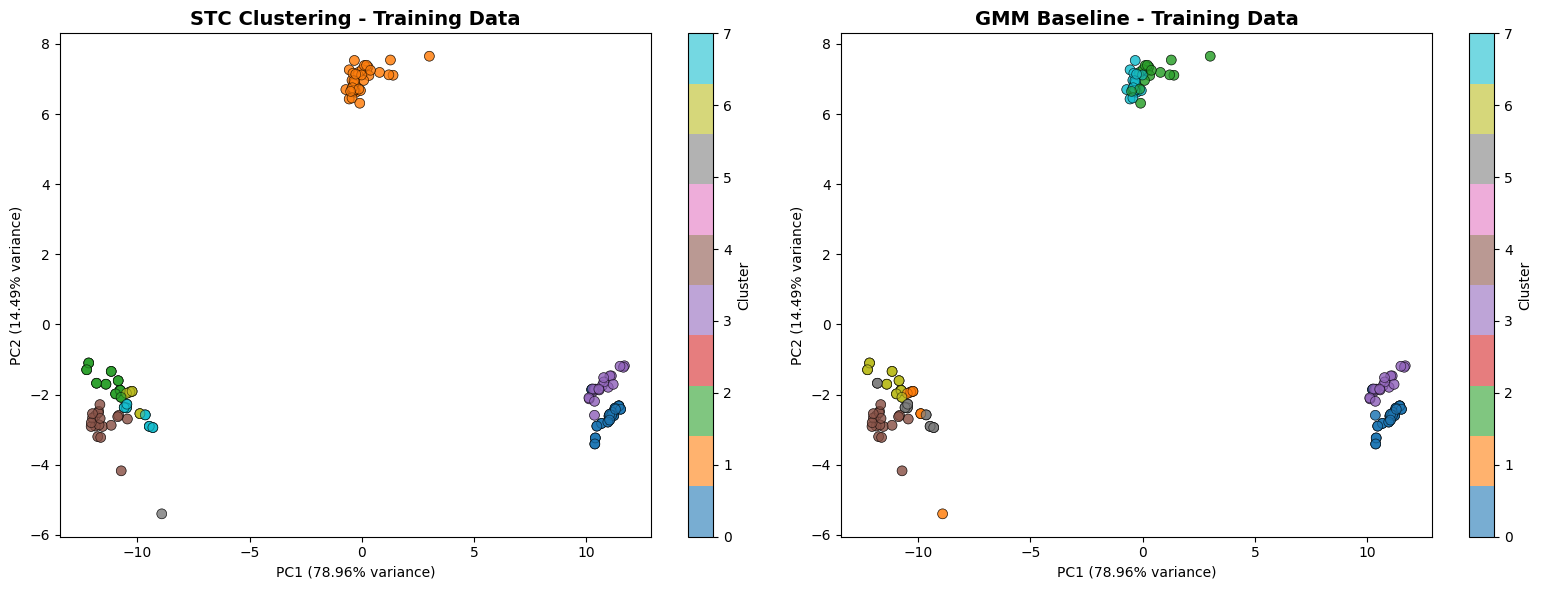

💾 Evaluation visualization saved


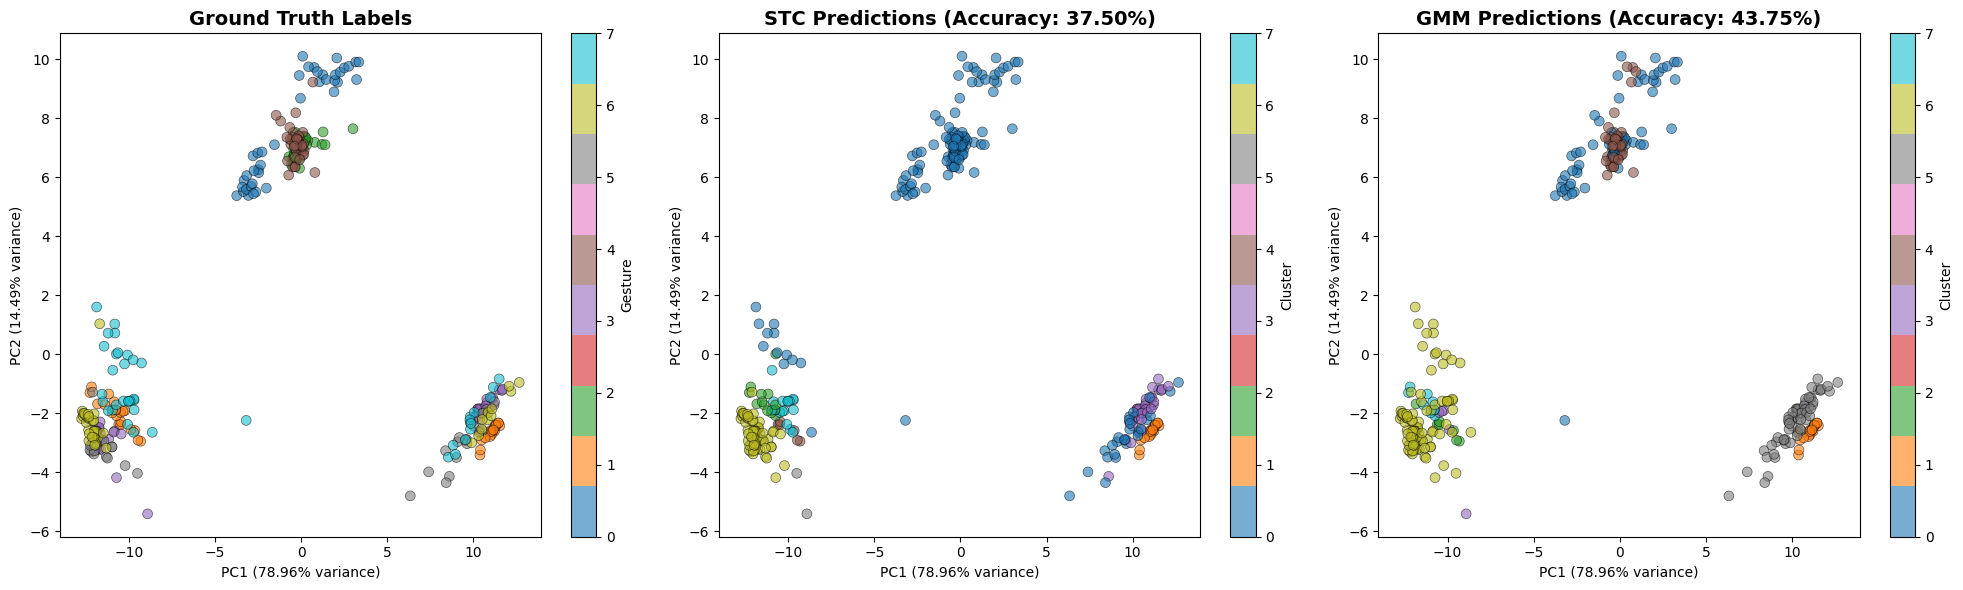

💾 Cluster distribution and eigenvalue spectrum saved


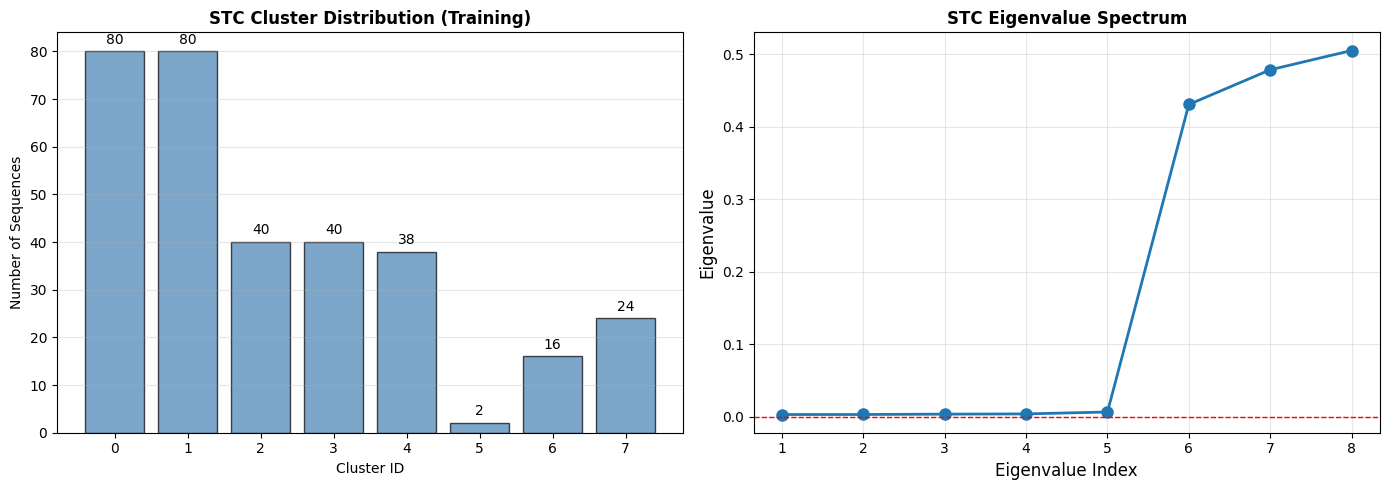

In [14]:
# ============================================================================
# VISUALIZATION: Results and Comparisons
# ============================================================================

print("\n" + "=" * 70)
print("Creating Visualizations")
print("=" * 70)

# Prepare data for visualization
mean_frames_train = np.array([np.mean(seq, axis=0) for seq in SEQUENCES_SCALED_TRAIN])
mean_frames_eval = np.array([np.mean(seq, axis=0) for seq in SEQUENCES_SCALED_EVAL])

# PCA for visualization (fit on training data)
pca = PCA(n_components=2, random_state=42)
mean_frames_pca_train = pca.fit_transform(mean_frames_train)
mean_frames_pca_eval = pca.transform(mean_frames_eval)

print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.4f}")

# Figure 1: Training data comparison (STC vs GMM)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
scatter = ax.scatter(mean_frames_pca_train[:, 0], mean_frames_pca_train[:, 1], 
                     c=stc_labels_train, cmap='tab10', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
ax.set_title('STC Clustering - Training Data', fontsize=14, fontweight='bold')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, ax=ax, label='Cluster')

ax = axes[1]
scatter = ax.scatter(mean_frames_pca_train[:, 0], mean_frames_pca_train[:, 1], 
                     c=gmm_labels_train, cmap='tab10', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
ax.set_title('GMM Baseline - Training Data', fontsize=14, fontweight='bold')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, ax=ax, label='Cluster')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'stc_vs_gmm_pca_comparison_train.png'), dpi=200, bbox_inches='tight')
print(f"💾 Training visualization saved")
plt.show()

# Figure 2: Evaluation data comparison (Ground Truth, STC, GMM)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

ax = axes[0]
scatter = ax.scatter(mean_frames_pca_eval[:, 0], mean_frames_pca_eval[:, 1], 
                     c=GESTURE_LABELS_EVAL, cmap='tab10', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
ax.set_title('Ground Truth Labels', fontsize=14, fontweight='bold')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, ax=ax, label='Gesture')

ax = axes[1]
scatter = ax.scatter(mean_frames_pca_eval[:, 0], mean_frames_pca_eval[:, 1], 
                     c=stc_labels_eval, cmap='tab10', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
ax.set_title(f'STC Predictions (Accuracy: {stc_accuracy:.2%})', fontsize=14, fontweight='bold')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, ax=ax, label='Cluster')

ax = axes[2]
scatter = ax.scatter(mean_frames_pca_eval[:, 0], mean_frames_pca_eval[:, 1], 
                     c=gmm_labels_eval, cmap='tab10', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
ax.set_title(f'GMM Predictions (Accuracy: {gmm_accuracy:.2%})', fontsize=14, fontweight='bold')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, ax=ax, label='Cluster')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'stc_vs_gmm_pca_comparison_eval.png'), dpi=200, bbox_inches='tight')
print(f"💾 Evaluation visualization saved")
plt.show()

# Figure 3: Cluster distribution and eigenvalue spectrum
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cluster distribution
ax = axes[0]
stc_counts = np.bincount(stc_labels_train)
ax.bar(range(len(stc_counts)), stc_counts, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Cluster ID')
ax.set_ylabel('Number of Sequences')
ax.set_title('STC Cluster Distribution (Training)', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for i, count in enumerate(stc_counts):
    ax.text(i, count + 1, str(count), ha='center', va='bottom')

# Eigenvalue spectrum
ax = axes[1]
ax.plot(range(1, len(stc.eigenvalues_) + 1), stc.eigenvalues_, 'o-', linewidth=2, markersize=8)
ax.set_xlabel('Eigenvalue Index', fontsize=12)
ax.set_ylabel('Eigenvalue', fontsize=12)
ax.set_title('STC Eigenvalue Spectrum', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='r', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cluster_distribution_and_spectrum.png'), dpi=200, bbox_inches='tight')
print(f"💾 Cluster distribution and eigenvalue spectrum saved")
plt.show()


In [15]:
# Visualization cells have been consolidated into Cell 12


In [16]:
# Visualization cells have been consolidated into Cell 12


In [17]:
# Summary statistics
print("\n" + "=" * 70)
print("Final Summary")
print("=" * 70)
print(f"Training sequences: {len(SEQUENCES_TRAIN)}")
print(f"Evaluation sequences: {len(SEQUENCES_EVAL)}")
print(f"Average training sequence length: {np.mean([len(s) for s in SEQUENCES_TRAIN]):.1f} frames")
print(f"Average evaluation sequence length: {np.mean([len(s) for s in SEQUENCES_EVAL]):.1f} frames")
print(f"\nSTC Parameters:")
print(f"  α (spatial weight): {stc.alpha}")
print(f"  Spatial neighbors: {stc.n_neighbors_spatial}")
print(f"  Temporal neighbors: {stc.n_neighbors_temporal}")
print(f"\nSTC Performance:")
print(f"  Silhouette Score: {stc_metrics['silhouette']:.6f}")
print(f"  Davies-Bouldin Score: {stc_metrics['davies_bouldin']:.6f}")
print(f"  Calinski-Harabasz Score: {stc_metrics['calinski_harabasz']:.2f}")
print(f"\nGMM Baseline Performance:")
print(f"  Silhouette Score: {gmm_metrics['silhouette']:.6f}")
print(f"  Davies-Bouldin Score: {gmm_metrics['davies_bouldin']:.6f}")
print(f"  Calinski-Harabasz Score: {gmm_metrics['calinski_harabasz']:.2f}")

print("\n✅ All analysis complete!")
print(f"📁 Results saved in: {output_dir}")



Final Summary
Training sequences: 320
Evaluation sequences: 320
Average training sequence length: 149.9 frames
Average evaluation sequence length: 149.1 frames

STC Parameters:
  α (spatial weight): 0.3
  Spatial neighbors: 5
  Temporal neighbors: 5

STC Performance:
  Silhouette Score: 0.700008
  Davies-Bouldin Score: 0.491460
  Calinski-Harabasz Score: 3482.46

GMM Baseline Performance:
  Silhouette Score: 0.533477
  Davies-Bouldin Score: 0.911403
  Calinski-Harabasz Score: 3453.01

✅ All analysis complete!
📁 Results saved in: STC_Results
